# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head(50)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story
6,Michael Booth,fresh,114709,Denver Post,"As Lion King did before it, Toy Story revived ...",2007-05-03,9559,Toy story
7,Geoff Andrew,fresh,114709,Time Out,The film will probably be more fully appreciat...,2006-06-24,9559,Toy story
8,Janet Maslin,fresh,114709,New York Times,Children will enjoy a new take on the irresist...,2003-05-20,9559,Toy story
9,Kenneth Turan,fresh,114709,Los Angeles Times,Although its computer-generated imagery is imp...,2001-02-13,9559,Toy story
10,Susan Wloszczyna,fresh,114709,USA Today,How perfect that two of the most popular funny...,2000-01-01,9559,Toy story


In [3]:
critics.describe()

,imdb,rtid
count,1.556100e+04,1.556100e+04
mean,1.566739e+05,5.704018e+07
std,1.588589e+05,1.829727e+08
min,1.344200e+04,1.100000e+01
25%,9.905200e+04,1.130600e+04
50%,1.163670e+05,1.336900e+04
75%,1.375230e+05,1.641600e+04
max,1.190539e+06,7.710318e+08


### Explore

In [4]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


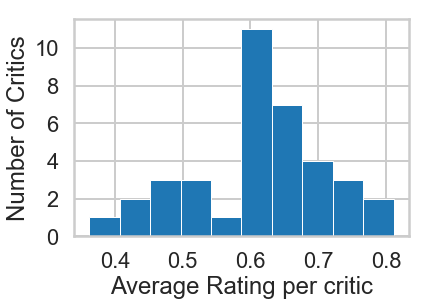

In [5]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [6]:
print(df['fresh'].nunique())
print(df.fresh.head())

2
1    True
2    True
3    True
4    True
5    True
Name: fresh, dtype: bool


<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

In [7]:
print('Exercise Set I:   Before studying the histogram above, I added the above line of code to better understand the fresh column added.  Apparently fresh is 1 and not fresh is 0, so average rating per critic must be a value between 0 and 1. The histogram shows us the spread of average ratings per criticis between .4 and .8.  Average rating seems slightly higher than expected so maybe all of the movies are decent or there is a simple random sample. It must be less common to have average ratings around the edges so I would expect this data to be more normally distributed.  It is interesting that on .55 average there is a dip and a high spike at .6.  Without knowing all of the details about the selection process for the movies, it is difficult to make any conclusions about this distribution. A theory why the highest average may be .6 is that this movie set may have a bunch of mediocre movies that are not super blockbusters.  So it might be commmon to see scores around the middle.  If the scoring system was not binary being fresh or not fresh, and was a multi-class score between 0 and 1, we could come up with a theory that the default score if the critic does not change it is .6.   Since this is not true in this case, that is not a valid theory. ')

Exercise Set I:   Before studying the histogram above, I added the above line of code to better understand the fresh column added.  Apparently fresh is 1 and not fresh is 0, so average rating per critic must be a value between 0 and 1. The histogram shows us the spread of average ratings per criticis between .4 and .8.  Average rating seems slightly higher than expected so maybe all of the movies are decent or there is a simple random sample. It must be less common to have average ratings around the edges so I would expect this data to be more normally distributed.  It is interesting that on .55 average there is a dip and a high spike at .6.  Without knowing all of the details about the selection process for the movies, it is difficult to make any conclusions about this distribution. A theory why the highest average may be .6 is that this movie set may have a bunch of mediocre movies that are not super blockbusters.  So it might be commmon to see scores around the middle.  If the scori

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [9]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

In [10]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(critics.quote)
X = X.tocsc()  # some versions of sklearn return COO format
y = (critics.fresh == 'fresh').values.astype(np.int)




## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [11]:
#your turn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

train_predicted = clf.predict(X_train)
print('Accuracy of MutlinomialNB train set: ' + str(np.mean(train_predicted == y_train)))
test_predicted = clf.predict(X_test)
print('Accuracy of MutlinomialNB test set: ' + str(np.mean(test_predicted == y_test)))
print('The accuracy of the prediction on the test set is a better indication of model performance.  High training data accuracy is a symptom of overfitting and the model may be memorizing input, output pairs. Also, the decision surface might be overly complex and including all of the noise from the input data and make generalizing to new data more difficult.')

Accuracy of MutlinomialNB train set: 0.9193658954584405
Accuracy of MutlinomialNB test set: 0.7661269596504755
The accuracy of the prediction on the test set is a better indication of model performance.  High training data accuracy is a symptom of overfitting and the model may be memorizing input, output pairs. Also, the decision surface might be overly complex and including all of the noise from the input data and make generalizing to new data more difficult.


### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [12]:
X = X.toarray()
X = pd.DataFrame(X, columns=vectorizer.get_feature_names())
X.head()

,000,0014,007,044,07,10,100,101,102,104,105,108,10th,11,110,112,1138,114,118,11th,12,124,125,128,13,130,131,132,133,134,136,137,13th,14,141,145,15,153,15th,16,160,161,1660s,16mm,16th,17,17th,18,180,185,...,zellweger,zemeckis,zen,zero,zeroes,zest,zestfully,zesty,zeta,zhang,zhivago,ziggurats,zigs,zigzag,zigzags,zillion,zimmer,zing,zinger,zingers,zings,zingy,zinnemann,zinner,zip,zipper,zippo,zippy,zips,zirconium,zoe,zombie,zombies,zombified,zonca,zone,zoning,zoo,zoological,zoom,zooming,zooms,zorro,zorros,zowie,zucker,zweibel,zwick,zzzzzs,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
word_doc_freq = X.sum(axis=0).reset_index()
word_doc_freq.columns = ['Word', 'Doc Freq']
word_doc_freq.head(10)

,Word,Doc Freq
0,000,8
1,0014,1
2,007,10
3,044,1
4,07,1
5,10,39
6,100,17
7,101,4
8,102,1
9,104,1


In [14]:
from collections import Counter

sorted_doc_freqs = np.sort(word_doc_freq['Doc Freq'])
counts = Counter(sorted_doc_freqs)
counts.most_common(5)

[(1, 9552), (2, 3486), (3, 1916), (4, 1259), (5, 896)]

In [15]:
counts = counts.items()
x_ax = np.array([item[0] for item in counts])
freqs = np.array([item[1] for item in counts])
y_ax = freqs.cumsum() / freqs.cumsum()[-1]

Text(0.5,1,'Zoomed in')

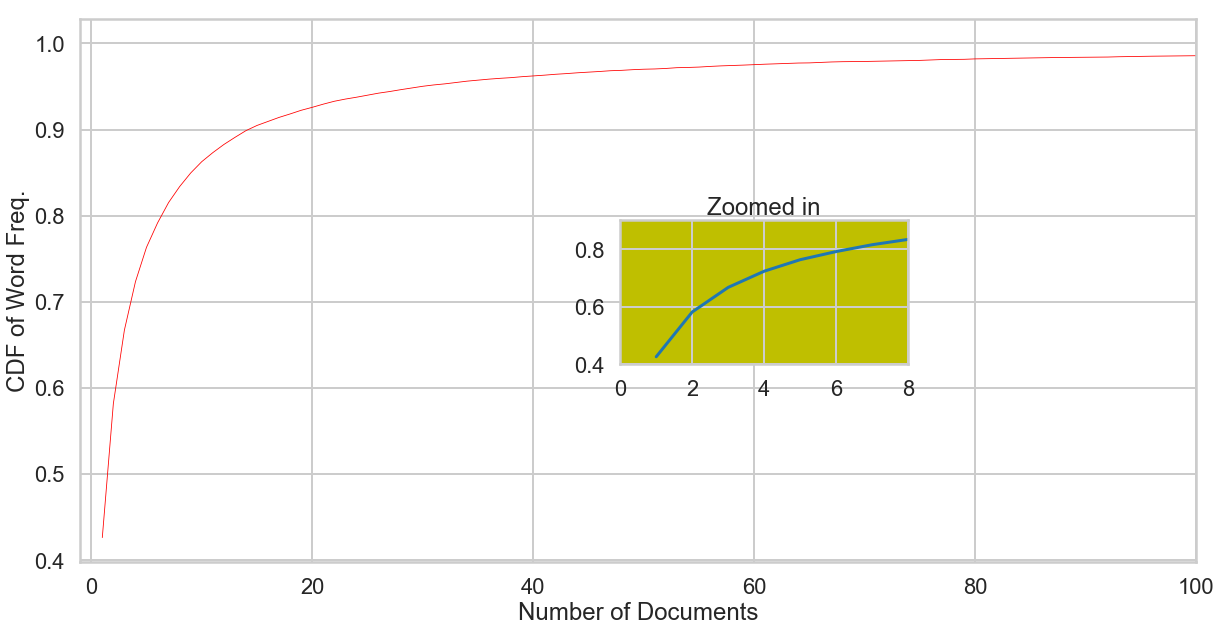

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.plot(x_ax , y_ax, linewidth=0.8, color='r')

plt.xlim(-1, 100)
plt.xlabel('Number of Documents')
plt.ylabel('CDF of Word Freq.')

a = plt.axes([.5, .4, .2, .2], facecolor='y')
          # Default margin is 0.05, value 0 means fit
a.plot(x_ax , y_ax)
plt.axis([0,8,.4,.9])
plt.title('Zoomed in')
# plt.xticks([])
# plt.yticks([])


In [17]:
print('The percentage of words that appears at X=5, or index 4 of y axis is ' + str(y_ax[4]))
print('It looks like the min df could be 0 and max df could be 100')

The percentage of words that appears at X=5, or index 4 of y axis is 0.7632154168711246
It looks like the min df could be 0 and max df could be 100


The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [18]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [19]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    print(prob)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [20]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [21]:
mask

array([ True, False, False, ..., False, False,  True])

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [22]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 0

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)

    Xtrainthis = X[mask]
    ytrainthis = y[mask]
    clf = MultinomialNB(alpha)
    if cv_score(clf, Xtrainthis, ytrainthis, log_likelihood) > maxscore:
        maxscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        best_alpha = alpha
print(maxscore)
print(best_alpha)

[[-1.54642293e-03 -6.47258391e+00]
 [-1.04315009e+01 -2.94892100e-05]
 [-3.38812211e+00 -3.43554867e-02]
 ...
 [-7.77163909e-01 -6.15645430e-01]
 [-1.23919169e+01 -4.15202305e-06]
 [-6.23266655e+00 -1.96613883e-03]]
[[-1.07669410e+01 -2.10853846e-05]
 [-3.39551279e+00 -3.40981496e-02]
 [-7.12425803e-04 -7.24719098e+00]
 ...
 [-5.39693758e+00 -4.54072734e-03]
 [-1.25747056e-02 -4.38234874e+00]
 [-6.35334815e-03 -5.06194833e+00]]
[[-3.15290453e-03 -5.76100721e+00]
 [-1.34096100e+00 -3.03261683e-01]
 [-5.48251008e+00 -4.16754965e-03]
 ...
 [-5.36722819e-02 -2.95157469e+00]
 [-1.38879869e-01 -2.04278238e+00]
 [-2.48839650e+00 -8.66947213e-02]]
[[-1.13046105e-01 -2.23595017e+00]
 [-2.30436300e-02 -3.78186559e+00]
 [-1.09048300e-02 -4.52399693e+00]
 ...
 [-3.48074880e-03 -5.66224770e+00]
 [-1.21392852e+00 -3.52438366e-01]
 [-3.54531995e-01 -1.20899095e+00]]
[[-4.97435284e-01 -9.36718554e-01]
 [-3.93617998e-01 -1.12273607e+00]
 [-1.32305682e+00 -3.09682265e-01]
 ...
 [-3.94439226e+00 -1.95528

In [23]:
print('The log likelihood value is ' + str(log_likelihood(clf, X_train, y_train)) + ' and is defined as the natural logarithm of the likelikhood. We are trying to maximize the score.')
print('If the alpha is too high, I believe there would be no significant changes to cv_score after a certain threshold.  Based on my research, for more complex sentences, increasing alpha may be necessary to smooth out the noisy data.')
print('From my code above, it appears the best alpha value is 1')

[[-3.61049179e+00 -2.74108136e-02]
 [-2.70992915e+00 -6.88587962e-02]
 [-2.74202623e+00 -6.66096189e-02]
 ...
 [-5.73104631e+00 -3.24895371e-03]
 [-1.92639272e+00 -1.57440944e-01]
 [-5.59972090e+00 -3.70575377e-03]]
The log likelihood value is -16772.10032112529 and is defined as the natural logarithm of the likelikhood. We are trying to maximize the score.
If the alpha is too high, I believe there would be no significant changes to cv_score after a certain threshold.  Based on my research, for more complex sentences, increasing alpha may be necessary to smooth out the noisy data.
From my code above, it appears the best alpha value is 1


In [24]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [25]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.928679
Accuracy on test data:     0.731362


In [26]:
print('The default value for alpha = 1, so there should be no difference between setting alpha = 1 or using default for Multinomial Naive Bayes.')
print('Comment on using masked data: We see a slight decrease in test data accuracy when using the masking process. The masking process made no changes in our model. The masking process only increased the test size from 25% to 30%, this explains why the test data accuracy went down a few points while training accuracy went up slightly.  It is time to start looking for other features to improve our model accuracy and concurrently closing the gap between training and test accuracy.')

The default value for alpha = 1, so there should be no difference between setting alpha = 1 or using default for Multinomial Naive Bayes.
Comment on using masked data: We see a slight decrease in test data accuracy when using the masking process. The masking process made no changes in our model. The masking process only increased the test size from 25% to 30%, this explains why the test data accuracy went down a few points while training accuracy went up slightly.  It is time to start looking for other features to improve our model accuracy and concurrently closing the gap between training and test accuracy.


In [27]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1986 2253]
 [ 673 5980]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [28]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]

ind = np.argsort(probs)
print(probs)
print(ind)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

[-0.76585493 -0.76585493 -1.49346511 ... -0.45451949 -0.76585493
 -0.45451949]
[20310 15913 16180 ...  2114 12950 19137]
Good words	     P(fresh | word)
            touching 0.96
              recent 0.96
          remarkable 0.96
                 key 0.94
         brilliantly 0.94
             delight 0.94
            greatest 0.94
              darkly 0.93
        exhilarating 0.93
          delightful 0.93
Bad words	     P(fresh | word)
            mediocre 0.13
               sorry 0.13
       disappointing 0.13
                lame 0.11
               waste 0.11
           pointless 0.11
               avoid 0.10
               bland 0.09
             muddled 0.09
              stupid 0.07


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

In [29]:
print('This method works because based on the data, the model utilized these features to be either strongest or weakest to make predictions.  The probability is the probability of the review being fresh given the word. ')

This method works because based on the data, the model utilized these features to be either strongest or weakest to make predictions.  The probability is the probability of the review being fresh given the word. 


The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [30]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

Nava, who started his feature-film career with El Norte, is a good director who invariably finds a strong rapport with his actors. He's not much of a writer, though, and he should think twice about creating dialogue for his future projects.

With the exception of Miss Streep's performance, the pleasures of Out of Africa are all peripheral -- David Watkin's photography, the landscapes, the shots of animal life -all of which would fit neatly into a National Geographic layout.

All of this would work better if Robinson built up the reality of the town more, made the citizens a more palpable presence, as Frank Capra did in Hollywood's greatest fable-fantasy, It's a Wonderful Life.

Because it falls in with the undulating rhythm of the l

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [31]:
#your turn
sentence = ['This movie is not remarkable, touching, or superb in any way']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(critics.quote)
X = X.tocsc()  # some versions of sklearn return COO format
y = (critics.fresh == 'fresh').values.astype(np.int)
#vectorizer  (train building 2D matrix,  when we do a transform,  fit - builds matrix,  fit transform- builds and returns. 
sent_vec = vectorizer.transform(sentence)
print(sent_vec)
pred = clf.predict(sent_vec)
print(pred)

  (0, 1015)	1
  (0, 9950)	1
  (0, 10535)	1
  (0, 12924)	1
  (0, 13400)	1
  (0, 13737)	1
  (0, 16180)	1
  (0, 19333)	1
  (0, 19995)	1
  (0, 20310)	1
  (0, 21772)	1
[1]


In [32]:
print('This is not the result we expected because our bag of words model does not deal with n-gram features.  The word not negates the positive sentiment words such as remarkable, touching, superb')

This is not the result we expected because our bag of words model does not deal with n-gram features.  The word not negates the positive sentiment words such as remarkable, touching, superb


### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [33]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [34]:
vectorizer = CountVectorizer(min_df=2, max_df=0.99, ngram_range=(1, 2))
X = vectorizer.fit_transform(critics.quote)
X = X.toarray()
X_df = pd.DataFrame(X, columns=vectorizer.get_feature_names())
X_df.head()

,000,000 leagues,007,007 formula,10,10 best,10 minute,10 minutes,10 times,10 year,10 years,100,100 million,100 minutes,100 percent,101,108,108 minutes,10th,11,11 year,110,110 million,112,118,118 minutes,12,12 angry,12 step,12 year,124,125,125 minutes,128,128 minutes,13,13 in,13 years,13th,13th warrior,14,141,145,15,15 minutes,15 years,16,16 months,160,17,...,youth,youth and,youth culture,youth movie,youthful,yugoslavia,yuk,yuks,yun,yun fat,zahn,zahn hilariously,zaillian,zaniness,zanuck,zanuck production,zany,zeal,zealand,zeitgeist,zellweger,zemeckis,zemeckis is,zen,zero,zest,zesty,zeta,zeta jones,zhang,zhang yimou,zigzag,zillion,zinger,zingers,zingy,zinnemann,zip,zippy,zoe,zoe cassavetes,zombie,zombies,zone,zone is,zoning,zooms,zorro,zucker,zwick
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
X = critics.quote

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logregpipe = Pipeline([
                      ('vectorizer', CountVectorizer(min_df=2, max_df=0.99, ngram_range=(1, 2))),
                     ('logreg', LogisticRegression(C=1))
                    ])
logreg = logregpipe.fit(X_train, y_train)
test_predicted = logreg.predict(X_test)
train_predicted = logreg.predict(X_train)

print('Accuracy of Log Reg train set: ' + str(np.mean(train_predicted == y_train)))
print('Accuracy of Log Reg test set: ' + str(np.mean(test_predicted == y_test)))

Accuracy of Log Reg train set: 0.9949443016281062
Accuracy of Log Reg test set: 0.7689539964019533


In [38]:
print('LOGREG: Great train set accuracy, and slight increase in test accuracy.')

LOGREG: Great train set accuracy, and slight increase in test accuracy.


In [39]:
MNBpipe = Pipeline([
                    ('vectorizer', CountVectorizer(min_df=2, max_df=0.99, ngram_range=(1, 2))),
                     ('clf', MultinomialNB())
                    ])

MNB = MNBpipe.fit(X_train, y_train)
test_predicted = MNB.predict(X_test)
train_predicted = MNB.predict(X_train)

print('Accuracy of MNB train set: ' + str(np.mean(train_predicted == y_train)))
print('Accuracy of MNB test set: ' + str(np.mean(test_predicted == y_test)))

Accuracy of MNB train set: 0.9446443873179091
Accuracy of MNB test set: 0.7722950398355178


In [40]:
from sklearn.ensemble import RandomForestClassifier
RFpipe = Pipeline([
                    ('vectorizer', CountVectorizer(min_df=2, max_df=0.99, ngram_range=(1, 2))),
                     ('rf', RandomForestClassifier(n_estimators=100, max_depth=5)) 
                    ])
rf = RFpipe.fit(X_train, y_train)
test_predicted = rf.predict(X_test)
train_predicted = rf.predict(X_train)

print('Accuracy of RF train set: ' + str(np.mean(train_predicted == y_train)))
print('Accuracy of RF test set: ' + str(np.mean(test_predicted == y_test)))


C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Accuracy of RF train set: 0.6107969151670951
Accuracy of RF test set: 0.6049858648162426


In [41]:
print('For Count Vectorizer, Best test accuracy between Logit, MNB, RF with 2 gram range so far is Logit. Next try TFIDF in Pipeline. ')

For Count Vectorizer, Best test accuracy between Logit, MNB, RF with 2 gram range so far is Logit. Next try TFIDF in Pipeline. 


In [42]:
# Your turn
# print(Xtfidf)
# tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1, 2))
# Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
# #Xtfidf = Xtfidf.toarray()
# X_df = pd.DataFrame(Xtfidf, columns=tfidfvectorizer.get_feature_names())
# X_df.head()

logregpipe = Pipeline([
                      ('vectorizer', TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1, 2))),
                     ('logreg', LogisticRegression(C=1))
                    ])
logreg = logregpipe.fit(X_train, y_train)
test_predicted = logreg.predict(X_test)
train_predicted = logreg.predict(X_train)

print('Accuracy of Log Reg train set: ' + str(np.mean(train_predicted == y_train)))
print('Accuracy of Log Reg test set: ' + str(np.mean(test_predicted == y_test)))

Accuracy of Log Reg train set: 0.9141388174807198
Accuracy of Log Reg test set: 0.7283474685170908


In [43]:
MNBpipe = Pipeline([
                     ('vectorizer', TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1, 2))),
                     ('clf', MultinomialNB())
                    ])

MNB = MNBpipe.fit(X_train, y_train)
test_predicted = MNB.predict(X_test)
train_predicted = MNB.predict(X_train)

print('Accuracy of MNB train set: ' + str(np.mean(train_predicted == y_train)))
print('Accuracy of MNB test set: ' + str(np.mean(test_predicted == y_test)))

Accuracy of MNB train set: 0.9320479862896315
Accuracy of MNB test set: 0.6671806733487535


In [44]:
RFpipe = Pipeline([
                    ('vectorizer', TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1, 2))),
                     ('rf', RandomForestClassifier(n_estimators=100, max_depth=5)) 
                    ])
rf = RFpipe.fit(X_train, y_train)
test_predicted = rf.predict(X_test)
train_predicted = rf.predict(X_train)

print('Accuracy of RF train set: ' + str(np.mean(train_predicted == y_train)))
print('Accuracy of RF test set: ' + str(np.mean(test_predicted == y_test)))

Accuracy of RF train set: 0.6107969151670951
Accuracy of RF test set: 0.6049858648162426


In [45]:
print('TFIDF did not beat Count Vectorizer in performance.  Move on to experimenting with word2vec')

TFIDF did not beat Count Vectorizer in performance.  Move on to experimenting with word2vec


In [46]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [47]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


critics['tokenized_text'] = critics['quote'].apply(word_tokenize) 

In [48]:
critics['tokenized_text'].head(50)

1     [So, ingenious, in, concept, ,, design, and, e...
2           [The, year, 's, most, inventive, comedy, .]
3     [A, winning, animated, feature, that, has, som...
4     [The, film, sports, a, provocative, and, appea...
5     [An, entertaining, computer-generated, ,, hype...
6     [As, Lion, King, did, before, it, ,, Toy, Stor...
7     [The, film, will, probably, be, more, fully, a...
8     [Children, will, enjoy, a, new, take, on, the,...
9     [Although, its, computer-generated, imagery, i...
10    [How, perfect, that, two, of, the, most, popul...
11    [The, result, is, a, visionary, roller-coaster...
12    [Disney, 's, witty, ,, wondrously, imaginative...
13    [Disney, 's, first, computer-made, animated, f...
14    [The, script, ,, by, Lasseter, ,, Pete, Docter...
15    [The, one, big, negative, about, Toy, Story, i...
16    [Technically, ,, Toy, Story, is, nearly, flawl...
17    [It, 's, a, nice, change, of, pace, to, see, t...
18    [I, can, hardly, imagine, having, more, fu

In [49]:
model = Word2Vec(critics['tokenized_text'])
print(model)


# convert column to list().  

Word2Vec(vocab=6365, size=100, alpha=0.025)


In [50]:
#need to tokenize each review to make it a list of words
#search tokenizer string,   
words = list(model.wv.vocab)
print(words)


['So', 'ingenious', 'in', 'concept', ',', 'design', 'and', 'execution', 'that', 'you', 'could', 'watch', 'it', 'on', 'a', 'screen', 'still', 'be', 'by', 'its', 'charm', '.', 'The', 'year', "'s", 'most', 'inventive', 'comedy', 'A', 'winning', 'animated', 'feature', 'has', 'something', 'for', 'everyone', 'the', 'age', 'film', 'sports', 'provocative', 'appealing', 'story', 'every', 'bit', 'equal', 'of', 'this', 'technical', 'achievement', 'An', 'entertaining', 'computer-generated', 'animation', '(', '1995', ')', 'also', 'effect', 'toy', 'As', 'Lion', 'King', 'did', 'before', 'Toy', 'Story', 'art', 'American', 'children', 'set', 'smart', 'movies', 'entertained', 'their', 'parents', 'It', 'landmark', 'movie', 'does', "n't", 'get', 'old', 'with', 'frequent', 'repetition', 'will', 'probably', 'more', 'fully', 'appreciated', 'adults', 'who', "'ll", 'love', 'snappy', 'knowing', 'verbal', 'gags', 'vivid', 'deftly', 'defined', 'characters', 'overall', 'sophistication', 'Children', 'enjoy', 'new',

In [51]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))


C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [52]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter (w2v.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [53]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter (w2v.values())))

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

etree_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [55]:
w2v_mean = etree_w2v.fit(X_train, y_train)
test_predicted = w2v_mean.predict(X_test)
train_predicted = w2v_mean.predict(X_train)

print('Accuracy of RF train set: ' + str(np.mean(train_predicted == y_train)))
print('Accuracy of RF test set: ' + str(np.mean(test_predicted == y_test)))

Accuracy of RF train set: 0.929305912596401
Accuracy of RF test set: 0.5610382934978154


In [56]:
print('Accuracy of test set is even worst than our previous logistic regression')

Accuracy of test set is even worst than our previous logistic regression


In [57]:
model.wv.save_word2vec_format('model.bin')

In [62]:
#Visualization of word model used in reviews

X = model[model.wv.vocab]




C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

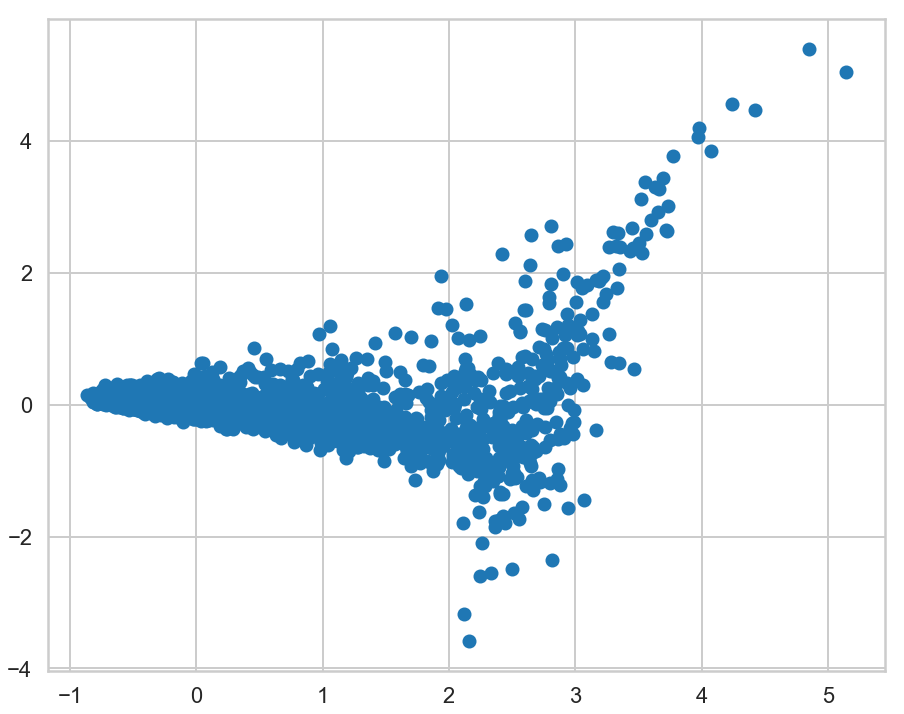

In [69]:
dims = (15, 12)
fix, ax = plt.subplots(figsize= dims)
plt.scatter(result[:, 0], result[:, 1])

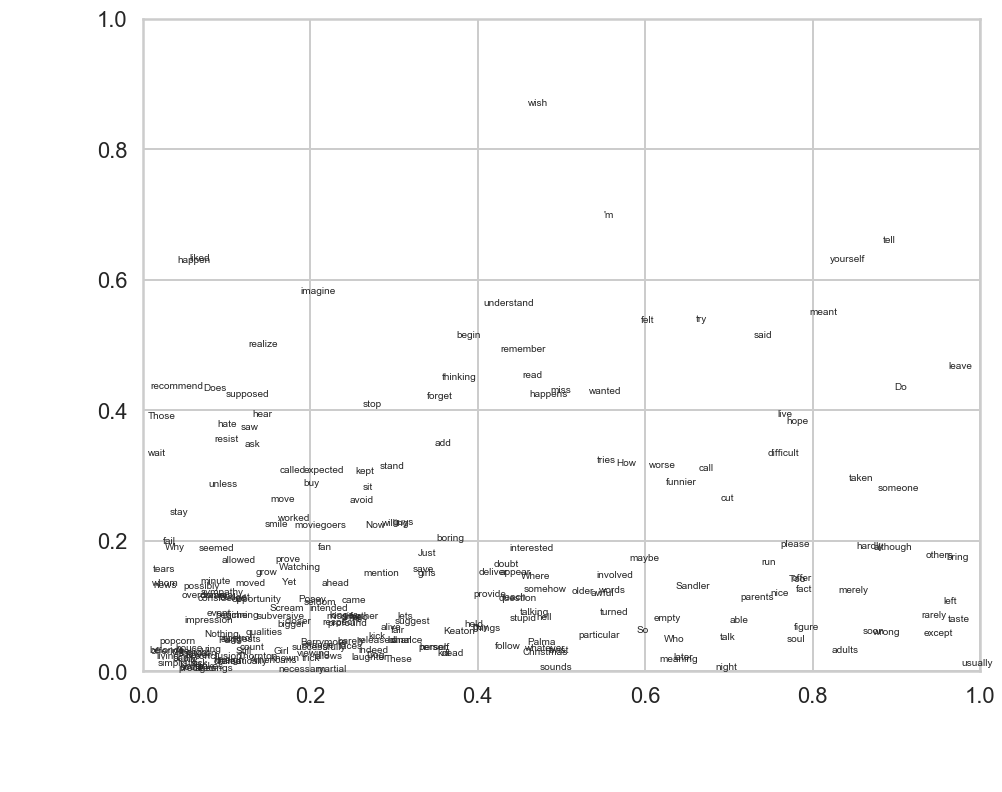

In [70]:
words = list(model.wv.vocab)
dims = (15, 12)
fix, ax = plt.subplots(figsize= dims)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

In [71]:
print('In summary Word2vec did not offer any improvement to our model.  Logistic Regression was still the champion in this case.')

In summary Word2vec did not offer any improvement to our model.  Logistic Regression was still the champion in this case.
